# Assignment 1
**Group 5**

Group members:
- Moqian Chen (r0965473)
- Laurens Dergent (r0794288)
- Sarah Guilliams (r0751825)
- Yeabsera Kinfu (r0930148)
- Jorge Puertolas Molina (r0978889)
- Isabel Scholz (r1008561)

Link to the GitHub repository: https://github.com/LaurensDergent/DataAnalytics.git

## Introduction

In today's competitive business environment, customer retention is critical for the success of any organization. A good churn prediction can help a business sustain customers.

This assignment delves into the prediction of customer churn using diverse machine learning techniques. The analysis at hand is comprised of several steps: the preprocessing of the data to make sure the data is compatible with the models, feature engineering to create new potentially meaningful predictors, and the evaluation of different machine learning models using the custom metric, profit top k. This assignment will also implement a fine-tuning of models to specifically target high scores in the "profit top k" metric. This involves not only optimizing model parameters through hyperparameter tuning, but also using sample weights to enhance the model's ability to identify high-spending customers who are most likely to churn.

In [265]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
#import featuretools as ft
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingRegressor
import os
from sklearn.inspection import PartialDependenceDisplay
import warnings

from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression



# To ignore all warnings
warnings.filterwarnings("ignore")

# To ignore specific warnings by category
# For example, to ignore all RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

trainval = pd.read_csv("C:/Users/jorge/train.csv")
test = pd.read_csv("C:/Users/jorge/test.csv")

Before proceeding further, a dictionary was created to personalize the pipeline and experiment with various combinations of methods for model training. This dictionary contains parameters that can be adjusted for preprocessing purposes. These parameters include featuretools, undersampling, oversampling, timecolumn, corrthresh, and corrthresh2.

The featuretools parameter decides whether the Featuretools package is used for feature engineering or not. The timecolumn parameter specifies whether the column of connection time of the user is included in the feature set. Undersampling and oversampling parameters control whether these techniques will be employed to address the class imbalance. The corrthresh and corrthresh2 parameters represent correlation thresholds for dropping variables. All these parameters will be further explained later in the analysis.

In [266]:
extra_params = {"feature_tools" : 1, "undersampling" : 1, "oversampling" : 1, "time_column" : 1, "corr_thresh" : 0.9, "corr_thresh2" : 0.65}

## Division of Sets

The initial step in the pipeline was partitioning the datasets. This entails separating the features from the dependent variable, as well as splitting the original training data into two subsets: the training set and the validation set. In this case, the validation set would be the equivalent of a test set, since the test set does not contain labels. This division is crucial for evaluating the models. All models were tested on the validation set, and then the best-performing one was selected for the leaderboard. The validation set was chosen to be 20 \% of the original training set. 

In [267]:
X_trainval = trainval.drop(columns = "target")
y_trainval = trainval["target"]

In [268]:
train, val, train_target, val_target = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [269]:
train['target'] = train_target
val['target'] = val_target

It was necessary to store the minimum average cost values separately because they are required for computing the top k metric. When scaling features, the original values of average cost min were lost, and this was a way of gathering them again when computing the metric.

In [270]:
#Keep average cost min
averagecostmin = val['average cost min']
idtest = test["id"]

## Initial Exploration

To start, we visualize the distributions of numerical variables. This is important to see whether any transformations should be applied to these variables. First, we can notice that the scaling of the variables vary a lot. PeakminsSum's maximum value is 2901, while WeekendRatio goes up to 0.74. This is important to take into account when inputting the data in models that are vulnerable to changes in the scaling of the variables. Second of all, most variables are not symmetric, implying they are not normally distributed. Most 75th quantiles are much farther from the median than 25th quantiles are. In this prediction environment where extreme values are likely to cause churnings, normalizing these variables was not considered to be suitable. High values could be the thing that causes churning and seeing this drastic difference between observations could help the model discriminate. By normalizing we make the line between high and medium values finer.

In [271]:
train.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,...,4032.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,31.414126,33.699347,2.673358,238.945229,708.792184,104.036431,311.938372,16.322677,50.079971,169.551549,...,10.081397,19.133955,73.501256,186.803427,0.168306,0.609716,0.327824,0.061717,0.162328,0.146716
std,12.775443,14.007828,3.418703,239.288923,503.929355,97.260823,199.167646,16.296733,36.092455,141.787096,...,2.108023,27.987193,60.000356,82.079489,0.077812,0.224430,0.209932,0.063644,0.105643,0.353867
min,12.000000,9.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.300000,0.000000,59.000000,307.500000,28.000000,149.550000,4.000000,22.800000,64.261044,...,8.573250,0.000000,32.134081,123.802373,0.134413,0.466317,0.165139,0.020942,0.078918,0.000000
50%,29.000000,33.666667,1.000000,161.000000,614.400001,73.000000,291.000000,11.000000,44.399999,132.279506,...,9.518597,7.515854,57.801016,173.254831,0.154525,0.654877,0.287722,0.043932,0.157734,0.000000
75%,39.000000,45.933333,2.000000,343.000000,1014.300000,156.000000,446.400000,24.000000,71.750000,236.853610,...,11.696253,28.308661,99.217719,232.116107,0.179302,0.782261,0.458395,0.080924,0.244154,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,106.000000,205.000000,935.947864,...,21.734694,184.892166,437.063835,587.063835,1.357564,1.000000,1.000000,0.731884,2.601223,1.000000


In [272]:
train.describe(include = 'object')

,Gender,Connect_Date,tariff,Handset,Usage_Band,Tariff_OK,high Dropped calls,No Usage,id
count,4035,4035,4035,4035,4032,4035,4035,4035,4035
unique,2,1310,5,11,5,4,2,2,4035
top,F,11/07/99,CAT 200,S50,Med,OK,F,F,K277140
freq,2042,11,1802,944,2232,4006,3933,4032,1


The table above was used to delete redundant variables. Along this line, the id variable was deleted. "Usage" was deleted from the model because it contributed little to no information, since out of 4035 observations, it had 4032 repetitions of "F". "Tariff OK" also showed the same characteristics, and had 4006 repetitions of "OK". However, it was retained because the remaining observations could still capture information on whether the client would churn or not.

In [273]:
train = train.drop(columns = ["id"])
val = val.drop(columns = ["id"])
test = test.drop(columns = ["id"])

## Preprocessing

#### Feature Engineering

A new variable called "ConnectTime" was created, that represented the amount of time the user has been connected for/affiliated with the company. This was hypothesized to be useful as it was a proxy of loyalty. For generating this variable, the values in the ConnectDate column were subtracted from the last date in the train set. Using the last date in the train set ensured that the cutoff point was the same for all the instances across all sets.

In [274]:
if extra_params["time_column"] == 1:
    train["Connect_Date"] = train["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    test["Connect_Date"] = test["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    val["Connect_Date"] = val["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    
    max_train = train["Connect_Date"].max()
    
    train["End_Date"] = max_train
    test["End_Date"] = max_train
    val["End_Date"] = max_train

    train["Connect_Time"] = train["End_Date"] - train["Connect_Date"]
    test["Connect_Time"] = test["End_Date"] - test["Connect_Date"]
    val["Connect_Time"] = val["End_Date"] - val["Connect_Date"]

    train["Connect_Time"] = train["Connect_Time"].apply(lambda x : x.days)
    test["Connect_Time"] = test["Connect_Time"].apply(lambda x : x.days)
    val["Connect_Time"] = val["Connect_Time"].apply(lambda x : x.days)

    train = train.drop(columns = ["End_Date"])
    test = test.drop(columns = ["End_Date"])
    val = val.drop(columns = ["End_Date"])

train = train.drop(columns = ["Connect_Date"])
test = test.drop(columns = ["Connect_Date"])
val = val.drop(columns = ["Connect_Date"])

#### Missing Values

In [275]:
train.isna().sum()

Gender                    0
Age                       0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls        0
No Usage            

In [276]:
rows_with_missing_values = train[train.isnull().any(axis=1)]

In [277]:
rows_with_missing_values[["call_cost_per_min", "Dropped_calls_ratio", "Usage_Band"]]

,call_cost_per_min,Dropped_calls_ratio,Usage_Band
3836,NaN,NaN,NaN
4301,NaN,NaN,NaN
3237,NaN,NaN,NaN


Out of 4035 observations, only three rows contain missing values. Therefore, a simple method sufficed for imputation.  Median and most-frequent imputation methods were implemented using the SimpleImputer package from sklearn. 

##### Imputing Numerical Columns

In [278]:
# Assuming 'data' is your dataset with missing values
# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data
imputer.fit(train[["call_cost_per_min", "Dropped_calls_ratio"]])

# Transform the data by replacing missing values with the median
test_clean = imputer.transform(test[["call_cost_per_min", "Dropped_calls_ratio"]])
train_clean = imputer.transform(train[["call_cost_per_min", "Dropped_calls_ratio"]])
val_clean = imputer.transform(val[["call_cost_per_min", "Dropped_calls_ratio"]])

In [279]:
train["call_cost_per_min"] = train_clean[:, 0]
test["call_cost_per_min"] = test_clean[:, 0]
val["call_cost_per_min"] = val_clean[:, 0]

train["Dropped_calls_ratio"] = train_clean[:, 1]
test["Dropped_calls_ratio"] = test_clean[:, 1]
val["Dropped_calls_ratio"] = val_clean[:, 1]

##### Imputing Categorical Column

In [280]:
# Initialize the imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(np.array(train["Usage_Band"]).reshape(-1, 1))

train["Usage_Band"] = imputer.transform(np.array(train["Usage_Band"]).reshape(-1, 1))[:, 0]
test["Usage_Band"] = imputer.transform(np.array(test["Usage_Band"]).reshape(-1, 1))[:, 0]
val["Usage_Band"] = imputer.transform(np.array(val["Usage_Band"]).reshape(-1, 1))[:, 0]

#### Variable Selection

##### Dropping numerical variables

In the process of refining the features of the training set, an analysis was conducted to examine the correlation among numerical variables. A correlation threshold (corrthresh) of 0.9 was employed to identify pairs of variables with significant correlation. Subsequently, these correlated variable pairs were grouped into clusters such that all connected pairs were in the same cluster. Then, within each cluster, the variable with the highest correlation with the target variable was selected for the final feature set. Hence, the higher the chosen correlation threshold, the less the number of variables that are dropped. The chosen correlation threshold (corrthresh) was high to ensure that valuable variables were not discarded.

In [281]:
correlation_matrix = train[train.select_dtypes(include=['number']).columns.tolist()].corr()

In [282]:
corrtarget = correlation_matrix['target']

In [283]:
# Make plot for this

In [284]:
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > extra_params["corr_thresh"]:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

In [285]:
high_correlation_pairs

[('L_O_S', 'Connect_Time'),
 ('Peak_calls_Sum', 'National_calls'),
 ('Peak_mins_Sum', 'National mins'),
 ('Peak_mins_Sum', 'All_calls_mins'),
 ('International_mins_Sum', 'Total_call_cost'),
 ('Nat_call_cost_Sum', 'actual call cost'),
 ('National mins', 'All_calls_mins'),
 ('All_calls_mins', 'Total_Cost'),
 ('Total_call_cost', 'Total_Cost'),
 ('Peak ratio', 'OffPeak ratio')]

In [286]:
def build_adjacency_list(pairs):
    adjacency_list = defaultdict(list)
    for u, v in pairs:
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

# Function to perform depth-first search (DFS) traversal to find connected components
def dfs(node, adjacency_list, visited, component):
    visited.add(node)
    component.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, adjacency_list, visited, component)

# Function to find connected components in the graph
def find_connected_components(pairs):
    adjacency_list = build_adjacency_list(pairs)
    visited = set()
    connected_components = []
    for node in adjacency_list:
        if node not in visited:
            component = []
            dfs(node, adjacency_list, visited, component)
            connected_components.append(component)
    return connected_components

# Find connected groups
connected_groups = find_connected_components(high_correlation_pairs)

In [287]:
def get_variables_to_drop(group, corrtarget):
    max_cor = 0
    var_max = ''
    for var in group:
        if abs(corrtarget[var]) > max_cor:
            var_max = var
            max_cor = abs(corrtarget[var])
    group.remove(var_max)

    return group

In [288]:
variables_to_drop = [get_variables_to_drop(group, corrtarget) for group in connected_groups]

In [289]:
drop_vars = [item for sublist in variables_to_drop for item in sublist]

In [290]:
train = train.drop(columns = drop_vars)

In [291]:
val = val.drop(columns = drop_vars)

In [292]:
test = test.drop(columns = drop_vars)

##### Dropping categorical variables

In [293]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

The variables UsageBand, tariff, and NoUsage show no valuable information to predict the target variable. Their distributions do not differentiate between churners and non-churners, suggesting minimal discriminatory power. However, High Dropped Calls seems like a good indicator for predicting churn, with a notably higher ratio of True values among churners compared to non-churners.

Furthermore, the variable TariffOk, particularly in the category of 100, shows a substantially higher presence among churners compared to non-churners. Encoding this variable using One-Hot encoding could enhance its predictive value.

Similarly, considering the variability in handset types across churning and non-churning groups, using one-hot encoding for handset appears to be a suitable option. This approach would enable the model to capture the nuances associated with different handsets and potentially improve predictive accuracy.


In [294]:
train = train.drop(columns = ["No Usage", "Usage_Band", "tariff"])
test = test.drop(columns = ["No Usage", "Usage_Band", "tariff"])
val = val.drop(columns = ["No Usage", "Usage_Band", "tariff"])

 Outliers are not dealt with since they are useful in the detection of churners. Churning could be the precise thing that is caused by outliers.

#### Variable Transformation

##### Numerical Variables

To make the numerical variables easier for the models, the numerical variables were transformed to a 0-1 scale using MinMaxScaler. As presented in the Initial Exploration, normalized was rejected since churning prediction benefits from extremes.

In [295]:
test['target'] = 0

In [296]:
# List of numerical variable names
numerical_features = train.select_dtypes(include=['number']).columns.tolist()

# List of categorical variable names (replace with actual categorical variable names)
categorical_features = train.select_dtypes(exclude=['number']).columns.tolist()

# Define the transformers
transformers = [
    ('num', MinMaxScaler(), numerical_features)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

# Apply the column transformer to the data
transformed_train = preprocessor.fit_transform(train)
transformed_val = preprocessor.transform(val)
transformed_test = preprocessor.transform(test)

# Convert the transformed data back to DataFrame
transformed_train = pd.DataFrame(transformed_train, columns=numerical_features + categorical_features)
transformed_test = pd.DataFrame(transformed_test, columns=numerical_features + categorical_features)
transformed_val = pd.DataFrame(transformed_val, columns=numerical_features + categorical_features)

# Only the numerical variables will be scaled to the range [0, 1]

##### Categorical Variables

Following the insights from the Variable Selection section, categorical variables were transformed using One-Hot Encoding, although not all levels of each categorical variable were included. Specifically, for TariffOk, only a binary variable indicating whether it was HighCat100 or not was added.

In [297]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Tariff_OK    
0       OK               3436
        High CAT 100        5
        High CAT 50         1
        High Play 100       1
1       OK                570
        High CAT 100       16
        High CAT 50         4
        High Play 100       2
Name: count, dtype: int64
target  high Dropped calls
0       F                  

In [298]:
# Encode binary variables using map
binary_mapping1 = {'M': 1, 'F': 0}
binary_mapping2 = {'T': 1, 'F': 0}

transformed_train['high Dropped calls'] = transformed_train['high Dropped calls'].map(binary_mapping2)
transformed_train['Gender'] = transformed_train['Gender'].map(binary_mapping1)
transformed_test['high Dropped calls'] = transformed_test['high Dropped calls'].map(binary_mapping2)
transformed_test['Gender'] = transformed_test['Gender'].map(binary_mapping1)
transformed_val['high Dropped calls'] = transformed_val['high Dropped calls'].map(binary_mapping2)
transformed_val['Gender'] = transformed_val['Gender'].map(binary_mapping1)


# Filter and encode categorical variables
# For categorical_1, keep only 'High CAT 100', encode the rest as 'Other'
transformed_train['Tariff_OK'] = transformed_train['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_test['Tariff_OK'] = transformed_test['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_val['Tariff_OK'] = transformed_val['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)

# Encode categorical_2 using one-hot encoding
encoded_train = pd.get_dummies(transformed_train, columns=['Handset'], dtype = int)
encoded_test = pd.get_dummies(transformed_test, columns=['Handset'], dtype = int)
encoded_val = pd.get_dummies(transformed_val, columns=['Handset'], dtype = int)

In [299]:
encoded_val['target'] = encoded_val['target'].astype('category')

In [300]:
X_train = encoded_train.drop(columns = "target")
y_train = encoded_train["target"]

In [301]:
X_val = encoded_val.drop(columns = "target")
y_val = encoded_val["target"]

In [302]:
X_test = encoded_test.drop(columns = "target")

In [303]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

#### Oversampling / Undersampling

There was a significant class imbalance, the number of churners was much lower than the number of non-churners. To fix this, oversampling and undersampling were implemented.

##### Oversampling

In [304]:
if extra_params["oversampling"] == 1:
    if X_train is not None and y_train is not None:
        # Ensure y_train is an array of integers
        #print("y_train data type:", type(y_train))

        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Update X_train and y_train with resampled data
        X_train = X_resampled
        y_train = y_resampled
    else:
        print("X_train or y_train is None. Please check the input data.")
else:
    print("Oversampling is disabled.")

##### Undersampling

In [305]:
# Apply RandomUnderSampler for undersampling
if extra_params["undersampling"] == 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    X_train = X_resampled
    y_train = y_resampled
else:
    print("Undersampling is disabled.")

In [306]:
X_train.columns

Index(['Age', 'L_O_S', 'Dropped_Calls', 'OffPeak_calls_Sum',
       'OffPeak_mins_Sum', 'Weekend_calls_Sum', 'Weekend_mins_Sum',
       'International_mins_Sum', 'AvePeak', 'AveOffPeak', 'AveWeekend',
       'National_calls', 'AveNational', 'Dropped_calls_ratio', 'Mins_charge',
       'call_cost_per_min', 'actual call cost', 'average cost min',
       'OffPeak ratio', 'Weekend ratio', 'Nat-InterNat Ratio', 'Gender',
       'Tariff_OK', 'high Dropped calls', 'Handset_ASAD170', 'Handset_ASAD90',
       'Handset_BS110', 'Handset_BS210', 'Handset_CAS30', 'Handset_CAS60',
       'Handset_S50', 'Handset_S80', 'Handset_SOP10', 'Handset_SOP20',
       'Handset_WC95'],
      dtype='object')

#### Feature tools

In the final preprocessing stage, feature engineering was performed using featuretools. Multiplication primitives were applied to generate interaction effects among features. Initially, the resulting matrix had approximately 2000 features.

Subsequently, a filtering process was implemented, starting with the elimination of variables containing only one unique value. Following this, variables uncorrelated with the target variable were dropped. Finally, another correlation threshold was applied to further cut down features, leading to a set of 73 variables.

In [307]:
from featuretools.selection import remove_highly_correlated_features
import featuretools as ft
 
if extra_params['feature_tools'] == 1:
    combined_df = pd.concat([X_train, X_val, X_test], ignore_index=True)
    averagecostmin = combined_df['average cost min']
    es = ft.EntitySet(id='EntitySet')
 
    # Add your DataFrame as an entity to the EntitySet
    es = es.add_dataframe(
        dataframe_name="AllDataFT",
        dataframe=combined_df,
        index = "index"
    )
 
    # Perform Deep Feature Synthesis (DFS)
    feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='AllDataFT',
                                      trans_primitives=['multiply_numeric'],
                                      max_depth=1)
 
    # Split the combined dataset back into train, validation, and test sets
    train_size = len(X_train)
    val_size = len(X_val)
 
    X_train = feature_matrix[:train_size]
    X_val = feature_matrix[train_size:train_size + val_size]
    X_test = feature_matrix[train_size + val_size:]
    X_train['target'] = y_train
    #Delete all variables with one unique value
    drop_vars_zero = []
    for var in X_train.columns:
        if len(X_train[var].unique()) == 1:
            drop_vars_zero.append(var)
    X_train = X_train.drop(columns = drop_vars_zero)
    X_val = X_val.drop(columns = drop_vars_zero)
    X_test = X_test.drop(columns = drop_vars_zero)
    #Drop variables (there are too many >2000)
    #Start by dropping uncorrelated variables to target
    correlation_matrix_init = X_train[X_train.select_dtypes(include=['number']).columns.tolist()].corr()
    corrtarget_init = correlation_matrix_init['target'].reset_index()
    drop_init = []
    for i in range(0, len(corrtarget_init)):
        if abs(corrtarget_init['target'][i]) <= 0.05:
            drop_init.append(corrtarget_init['index'][i])
    X_train = X_train.drop(columns = drop_init)
    X_val = X_val.drop(columns = drop_init)
    X_test = X_test.drop(columns = drop_init)


    X_train = X_train.drop(columns = "target")
    threshold = extra_params["corr_thresh2"]
    
    # Remove highly correlated features
    X_train = remove_highly_correlated_features(X_train, pct_corr_threshold = threshold)
    X_val = X_val[X_train.columns]
    X_test = X_test[X_train.columns]
    #X_train['average cost min'] = averagecostmin[:train_size]
    #X_val['average cost min'] = averagecostmin[train_size:train_size + val_size]
    #X_test['average cost min'] = averagecostmin[train_size+val_size:]


In [308]:
X_train

,Age,L_O_S,Dropped_Calls,OffPeak_calls_Sum,Weekend_mins_Sum,National_calls,Dropped_calls_ratio,call_cost_per_min,average cost min,Weekend ratio,...,Gender * Nat-InterNat Ratio,Handset_BS110 * Mins_charge,Handset_BS110 * high Dropped calls,Handset_S50 * L_O_S,L_O_S * OffPeak ratio,L_O_S * Weekend_calls_Sum,National_calls * Weekend_calls_Sum,OffPeak ratio * Weekend_calls_Sum,actual call cost * Handset_CAS60,average cost min * OffPeak ratio
index,,,,,,,,,,,,,,,,,,,,,
0,0.058824,0.797529,0.066667,0.851786,0.213659,0.294755,0.001934,0.343557,0.040380,0.053653,...,0.000000,0.000000,0.0,0.000000,0.531114,0.195620,0.072298,0.163346,0.000000,0.026891
1,0.220588,0.822924,0.066667,0.183929,0.219512,0.108894,0.005236,0.557666,0.091945,0.137643,...,0.000000,0.362974,0.0,0.000000,0.410633,0.023290,0.003082,0.014122,0.000000,0.045880
2,0.176471,0.401510,0.733333,0.273214,0.000000,0.145952,0.042969,0.420027,0.061052,0.000000,...,0.040885,0.000000,0.0,0.000000,0.295329,0.000000,0.000000,0.000000,0.018364,0.044907
3,0.588235,0.096088,0.066667,0.285714,0.195122,0.155644,0.003663,0.337184,0.052613,0.059354,...,0.000000,0.000000,0.0,0.000000,0.064114,0.007252,0.011747,0.050358,0.000000,0.035106
4,0.279412,0.634866,0.066667,0.033929,0.214634,0.026796,0.021277,0.364935,0.069484,0.049620,...,0.000000,0.407981,0.0,0.000000,0.078284,0.065882,0.002781,0.012796,0.000000,0.008568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6881,0.316507,0.187908,0.069659,0.149846,0.625178,0.241371,0.004563,0.391489,0.089305,0.202347,...,0.045024,0.000000,0.0,0.000000,0.034811,0.110914,0.142471,0.109350,0.000000,0.016544
6882,0.287263,0.368289,0.257909,0.075575,0.578309,0.060351,0.043441,0.329015,0.153163,0.561573,...,0.000000,0.000000,0.0,0.368289,0.152598,0.189680,0.031083,0.213400,0.000000,0.063462
6883,0.204928,0.437138,0.330861,0.048787,0.355265,0.118163,0.016899,0.562846,0.102264,0.102677,...,0.080733,0.000000,0.0,0.000000,0.049875,0.102640,0.027745,0.026789,0.000000,0.011668


In [264]:
X_val = X_val.reset_index(drop = True)
combined_df['average cost min']

0       0.040380
1       0.091945
2       0.061052
3       0.052613
4       0.069484
          ...   
9572    0.056049
9573    0.087503
9574    0.059979
9575    0.119850
9576    0.046733
Name: average cost min, Length: 9577, dtype: float64

## top_20 metric

Once an estimator is trained, the function would directly output the
aggregation of top 20 profits from the true positive cases.

In [43]:
def profit_top_20(X_val, y_pred, y_val): ###### PLEASE LET'S KEEP IT THIS WAY FOR THE REMAINNING TIME!!

    true_positives = []
    for idx, (pred, true_label) in enumerate(zip(y_pred, y_val)):
        if pred == 1 and true_label == 1:
            true_positives.append(idx)

    cost_sort = pd.DataFrame()
    cost = X_val['average cost min'][true_positives]
    
    cost_sort['cost']=cost

    cost_sort.sort_values('cost', ascending=False, inplace=True)
    top_20_sum = cost_sort.head(20).sum()

    return top_20_sum

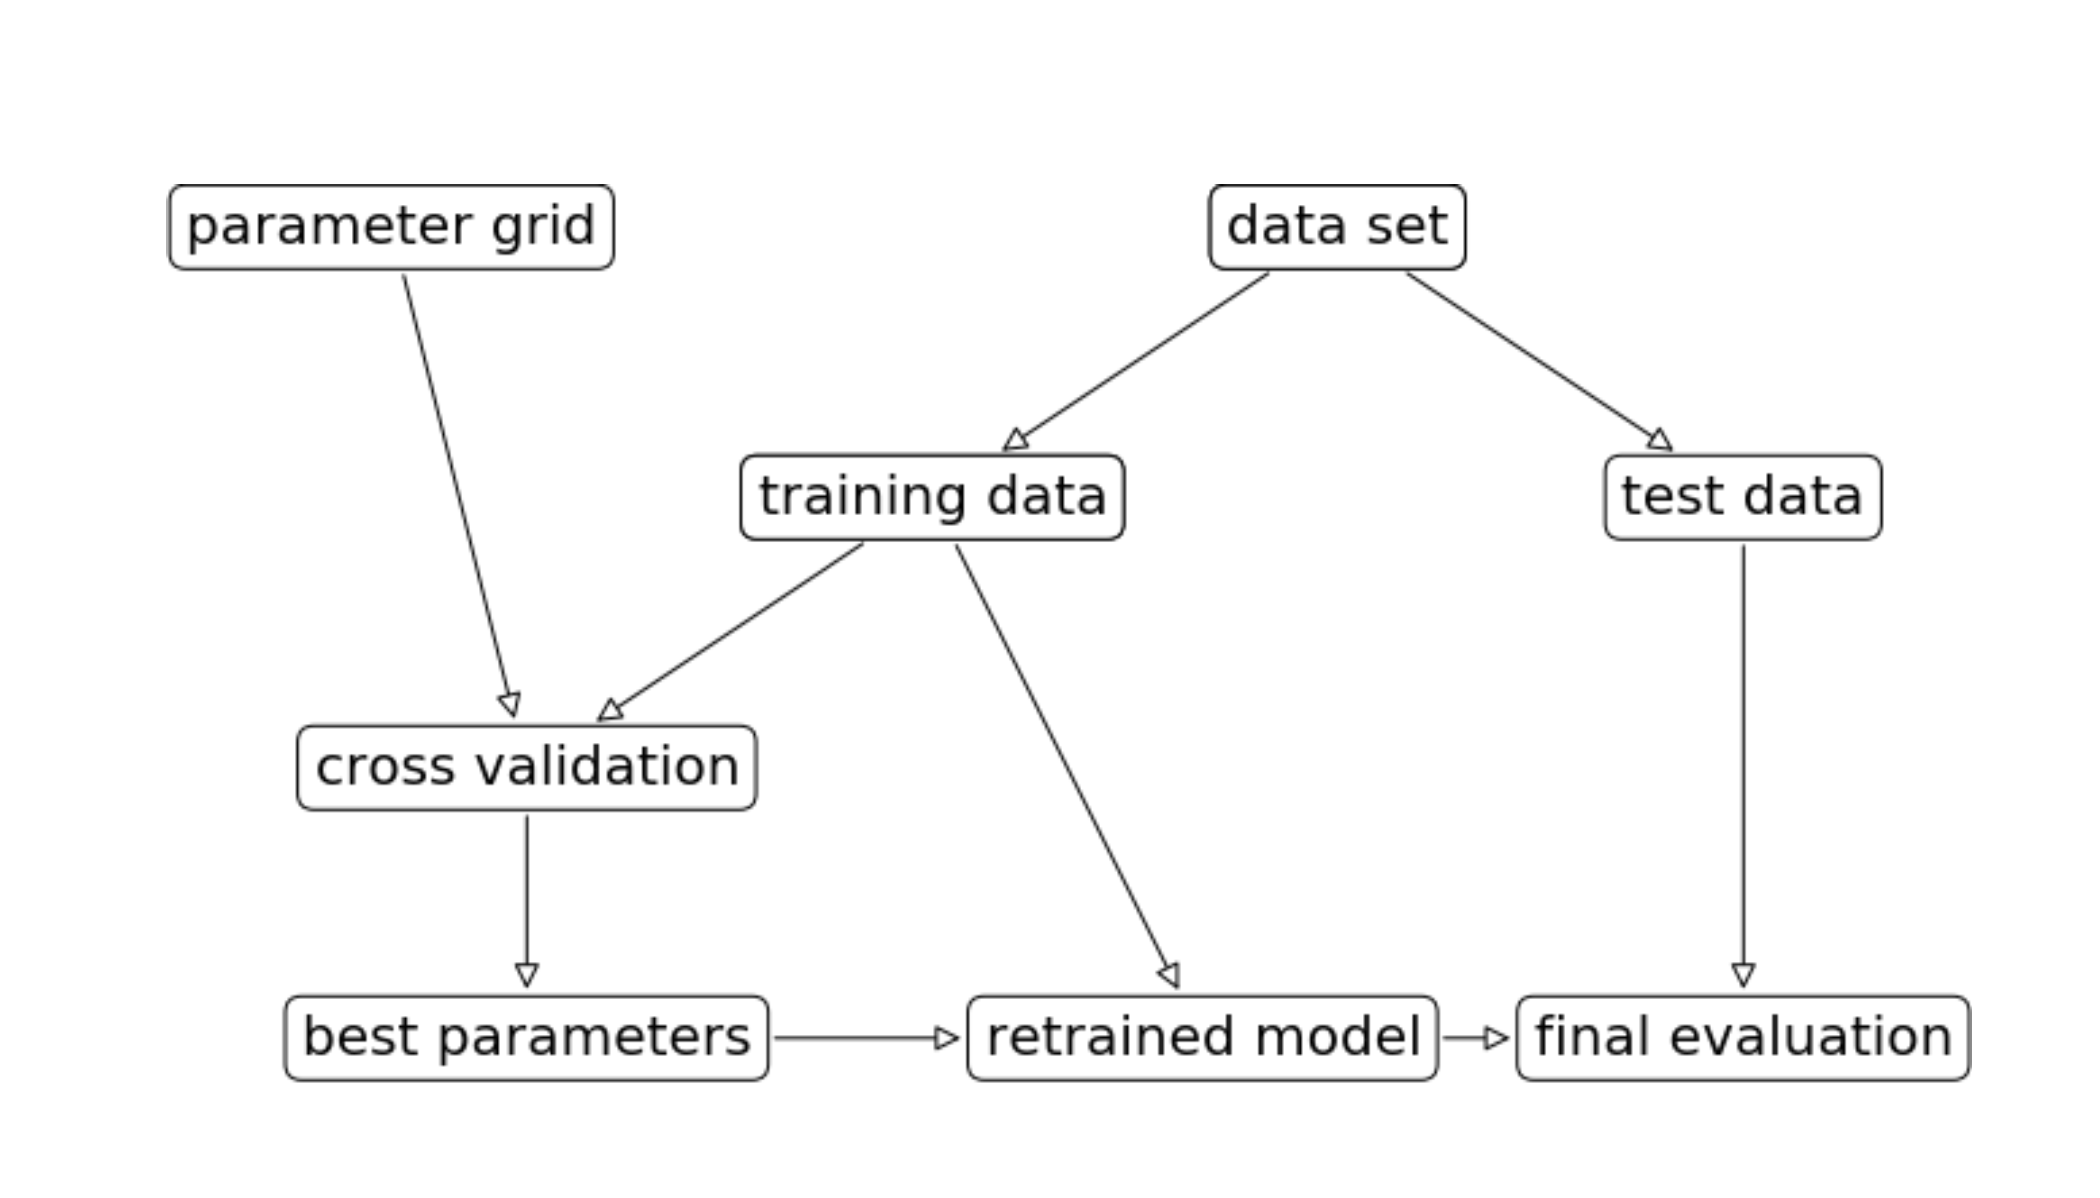

## Assign weights to samples

Would-be churners with higher cost are of more profitability. Hence,
weights are assigned to samples as clients of higher values are more
focal. Weights are determined in an exponential way instead of a linear
way, indicating that observations with higher cost would get way more
attention in the models.

In [44]:
X_val1,y_val1 = val, val_target
y_train_df = pd.DataFrame(y_train, columns=['target'])
Combined_set = pd.concat([X_train, y_train_df], axis = 1 )
Combined_set.sort_values(by='average cost min')
Combined_set_sorted = Combined_set.sort_values(by='average cost min',  ascending=False)

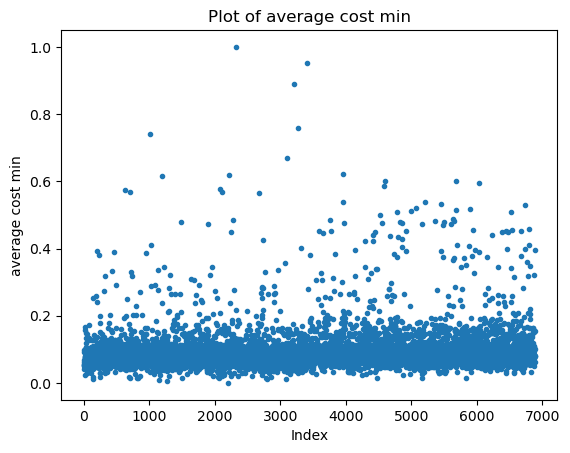

In [86]:
X_val1,y_val1 = val, val_target
y_train_df = pd.DataFrame(y_train, columns=['target'])
Combined_set = pd.concat([X_train, y_train_df], axis = 1 )
Combined_set.sort_values(by='average cost min')
Combined_set_sorted = Combined_set.sort_values(by='average cost min',  ascending=False)
plt.scatter(Combined_set.index, Combined_set["average cost min"], marker='.')
plt.ylabel("average cost min")
plt.xlabel("Index")
plt.title("Plot of average cost min")
plt.show()

In [47]:
Combined_set_sorted = Combined_set_sorted.reset_index(drop=True)
X_train_filt = Combined_set_sorted.drop(columns = "target")
y_train_filt = Combined_set_sorted["target"]

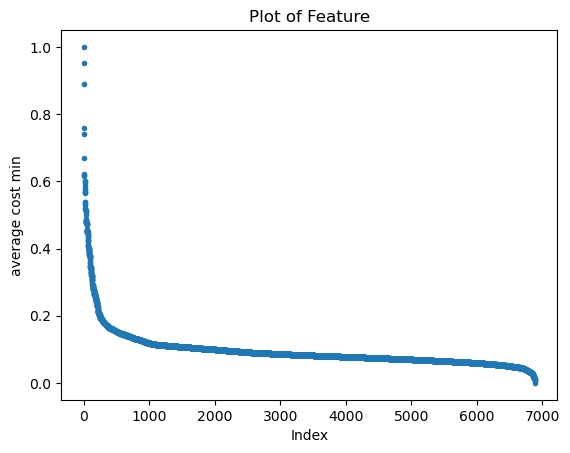

In [48]:
plt.scatter(X_train_filt.index, X_train_filt["average cost min"], marker='.')
plt.ylabel("average cost min")
plt.xlabel("Index")
plt.title("Plot of Feature")
plt.show()

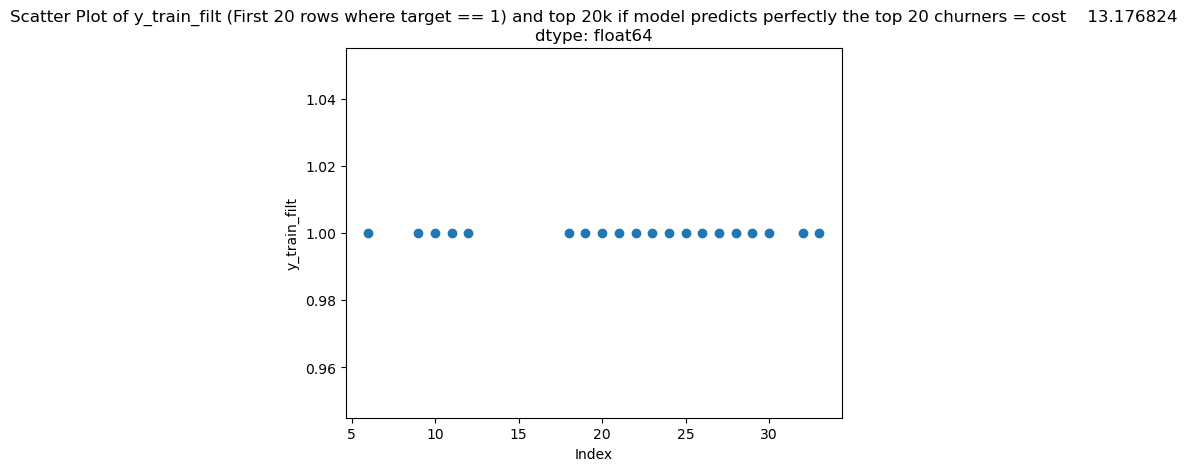

In [85]:
# Filter Combined_set_sorted to include only rows where 'target' is equal to 1
filtered_data = Combined_set_sorted[Combined_set_sorted["target"] == 1]

# Select the first 20 rows
filtered_data_first_20 = filtered_data.head(20)

# Get the target values from the filtered DataFrame
y_train_filt20 = filtered_data_first_20["target"]
#print(y_train_filt20)
def profit_top_20_scrap(X_train_filt,pred, y_val):

    true_positives = []
    for idx, (pred, true_label) in enumerate(zip(pred, y_val)):
        if pred == 1 and true_label == 1:
            true_positives.append(idx)
            
    cost_sort = pd.DataFrame()
    cost = X_train_filt['average cost min'][true_positives]
    
    cost_sort['cost']=cost

    cost_sort.sort_values('cost', ascending=False, inplace=True)
    #print(cost_sort)
    top_20_sum = cost_sort.head(20).sum()
    
    

    return top_20_sum

##If model perfect our topk is 
perf= profit_top_20_scrap(X_train_filt, y_train_filt20, y_train_filt20)

# Plot a scatter plot of y_train_filt against the index
plt.scatter(filtered_data_first_20.index, y_train_filt20)
plt.title(f'Scatter Plot of y_train_filt (First 20 rows where target == 1) and top 20, if model predicts perfectly the top 20 churners = {perf}')
plt.xlabel('Index')
plt.ylabel('y_train_filt')
plt.show()

The visualizations and analysis show that focusing on the top 1000
predictions is a practical and effective way to ensure high profits in
the top 20.

The decision to use a decreasing exponential function for weighting the
training data further reinforces this strategy. Exponential weighting
places higher importance on the top-ranked data points, aligning the
model's focus with the most critical predictions. This method ensures
that the model is trained to prioritize and perform exceptionally well
on the most valuable subset of predictions, which ultimately drives
higher profits in the top 20.

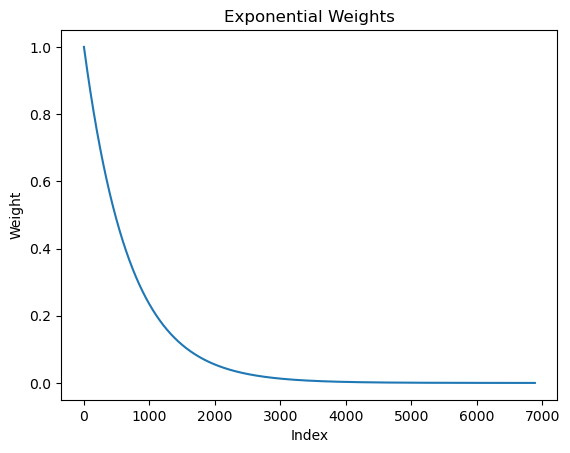

In [84]:
# Generate decreasing exponential weights
weights = np.exp(np.linspace(0, -10, len(y_train_filt)))

# Plot the weights
plt.plot(weights)
plt.title('Exponential Weights')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.show()

Firstly, models set by default parameters are trained for reference.

The following code is designed to evaluate several machine learning models using
cross-validation and ROC curves, with an emphasis on adjusting sample
weights to emphasis more on top average cost min. It includes models
such as Logistic Regression, Random Forest, Bagging Classifier, and
XGBoost Classifier. By iterating over different values of k from 1 to 15 every 3 steps, which
adjusts the weights applied to the samples using an exponential
function, the code systematically explores the impact of varying sample
emphasis on model performance.

For each value of k, a new figure is created to plot the ROC curves for
each model side-by-side. Within the nested loop, each model is trained
and evaluated. Special handling is applied to the XGBoost Classifier due
to its requirement for categorical data to be in a specific format.

Cross-validation scores are computed using the ROC\AUC metric, which
evaluates the model's ability to distinguish between classes. The models
are then fitted with the computed sample weights, and predictions are
made on a validation set.

The evaluation process includes calculating the confusion matrix, which
provides insight into the types of errors made by the model, and
computing the AUC score, which is averaged over the cross-validation
folds. The ROC curve for each model is plotted, displaying the true
positive rate against the false positive rate, with the AUC and a custom
profit metric shown in the legend. This visualization helps in comparing
the models' discriminative abilities.

Overall, this approach provides a comprehensive evaluation of different
models under varying conditions of sample weighting, which is crucial
for understanding their performance . It ensures that the models are
assessed not just on their accuracy, but also on their robustness and
ability to handle different emphasis on training samples, thus providing
a more reliable measure of their real-world applicability.

Confusion matrix for Logistic Regression:
[[787  69]
 [ 33 120]]
AUC for Logistic Regression: 0.9173805417066759
for k in the weights :  1
Confusion matrix for Random Forest:
[[811  45]
 [ 38 115]]
AUC for Random Forest: 0.941425501554083
for k in the weights :  1
Confusion matrix for BaggingClassifier:
[[804  52]
 [ 46 107]]
AUC for BaggingClassifier: 0.829544583971795
for k in the weights :  1
Confusion matrix for XGBClassifier:
[[805  51]
 [ 40 113]]
AUC for XGBClassifier: 0.8979800283427185
for k in the weights :  1


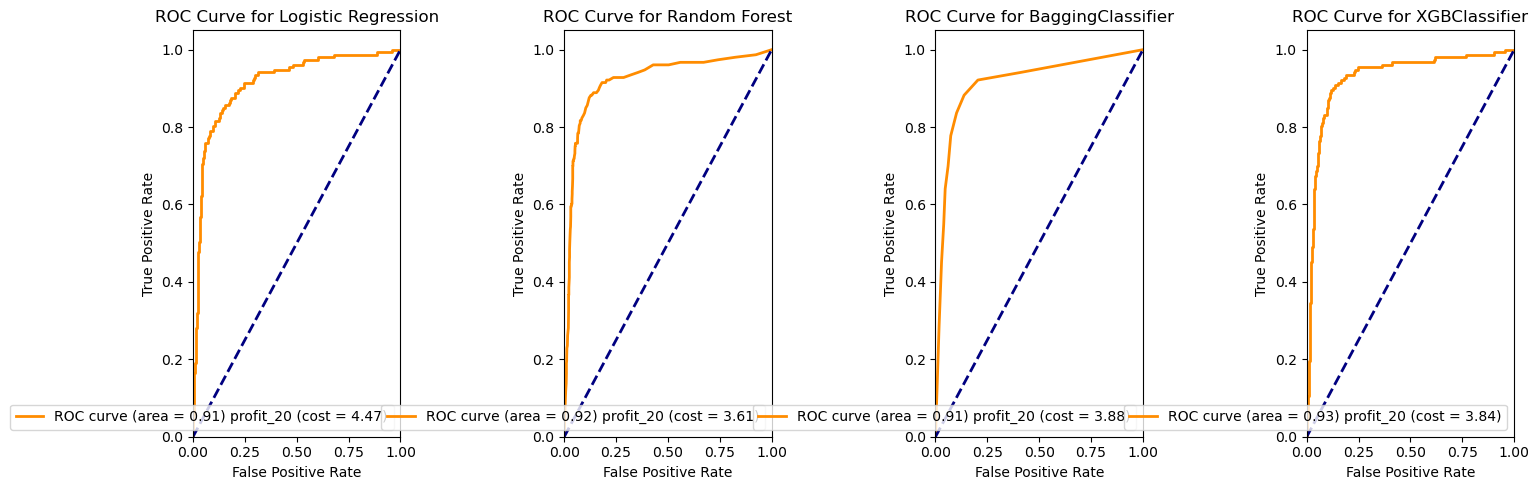

Confusion matrix for Logistic Regression:
[[770  86]
 [ 31 122]]
AUC for Logistic Regression: 0.9078249363898099
for k in the weights :  4
Confusion matrix for Random Forest:
[[816  40]
 [ 40 113]]
AUC for Random Forest: 0.9310419089856599
for k in the weights :  4
Confusion matrix for BaggingClassifier:
[[812  44]
 [ 40 113]]
AUC for BaggingClassifier: 0.7555080669659433
for k in the weights :  4
Confusion matrix for XGBClassifier:
[[803  53]
 [ 35 118]]
AUC for XGBClassifier: 0.8880053959968557
for k in the weights :  4


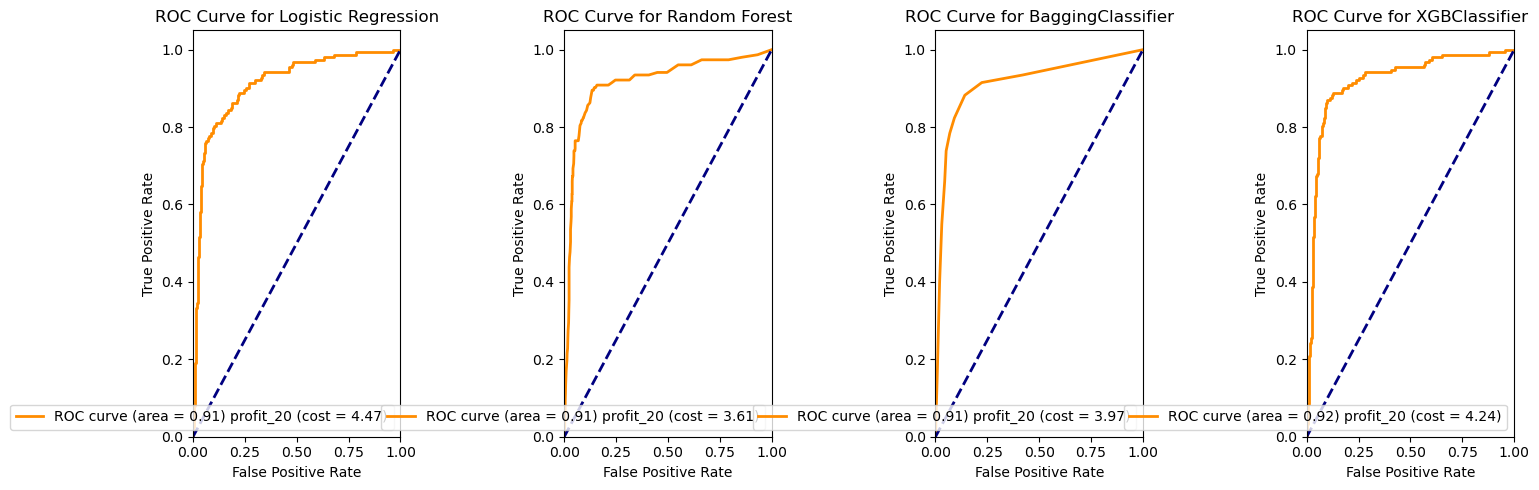

Confusion matrix for Logistic Regression:
[[690 166]
 [ 28 125]]
AUC for Logistic Regression: 0.891784084879623
for k in the weights :  7
Confusion matrix for Random Forest:
[[820  36]
 [ 45 108]]
AUC for Random Forest: 0.9274684560130618
for k in the weights :  7
Confusion matrix for BaggingClassifier:
[[807  49]
 [ 48 105]]
AUC for BaggingClassifier: 0.7283890114061121
for k in the weights :  7
Confusion matrix for XGBClassifier:
[[775  81]
 [ 36 117]]
AUC for XGBClassifier: 0.8681374783514213
for k in the weights :  7


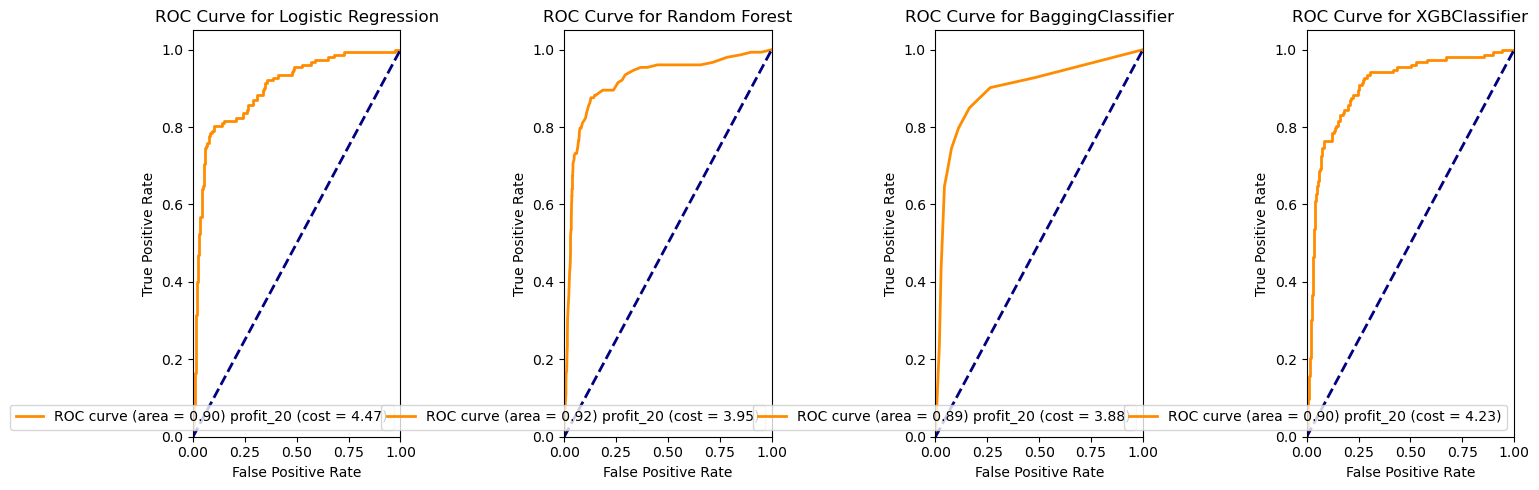

Confusion matrix for Logistic Regression:
[[629 227]
 [ 27 126]]
AUC for Logistic Regression: 0.8735695380047709
for k in the weights :  10
Confusion matrix for Random Forest:
[[814  42]
 [ 48 105]]
AUC for Random Forest: 0.9232027589228299
for k in the weights :  10
Confusion matrix for BaggingClassifier:
[[811  45]
 [ 51 102]]
AUC for BaggingClassifier: 0.7325003457967453
for k in the weights :  10
Confusion matrix for XGBClassifier:
[[742 114]
 [ 43 110]]
AUC for XGBClassifier: 0.8067768293327543
for k in the weights :  10


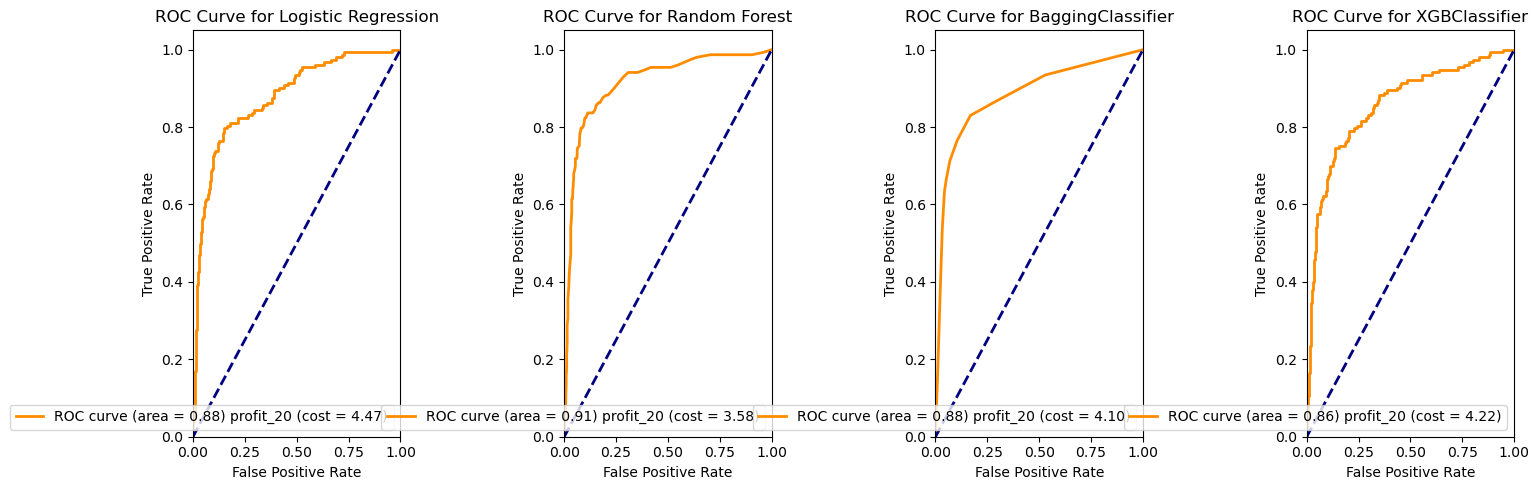

Confusion matrix for Logistic Regression:
[[561 295]
 [ 25 128]]
AUC for Logistic Regression: 0.8595128035546754
for k in the weights :  13
Confusion matrix for Random Forest:
[[815  41]
 [ 48 105]]
AUC for Random Forest: 0.9253614460841455
for k in the weights :  13
Confusion matrix for BaggingClassifier:
[[808  48]
 [ 52 101]]
AUC for BaggingClassifier: 0.7018853157592736
for k in the weights :  13
Confusion matrix for XGBClassifier:
[[686 170]
 [ 43 110]]
AUC for XGBClassifier: 0.8079590185113871
for k in the weights :  13


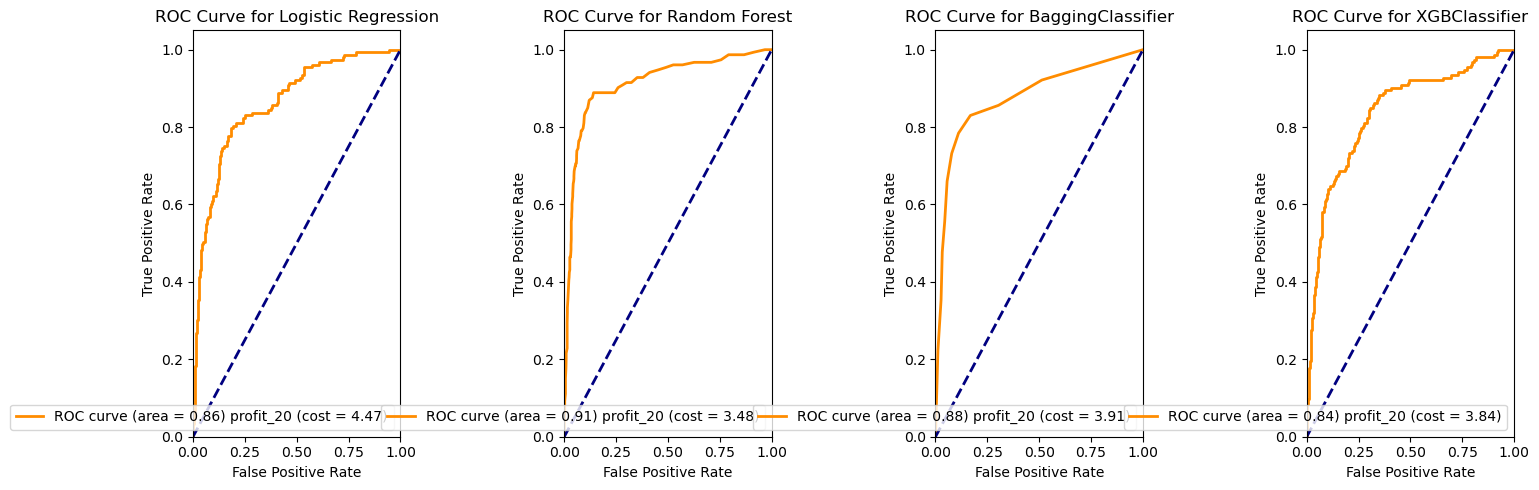

In [87]:

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    #'KNeighborsClassifier': KNeighborsClassifier(),
    #'MLPClassifier': MLPClassifier(),
    'BaggingClassifier': BaggingClassifier(),
     'XGBClassifier': XGBClassifier(),
    
}

for k in range (1, 15,3):
    plt.figure(figsize=(15, 5))  # Create a figure for subplots

    for i, (name, model) in enumerate(models.items(), 1):
        weights = np.exp(np.linspace(0, -k, len(y_train_filt)))

        plt.subplot(1, len(models), i)  # Create subplots

        # Use cross-validation to train the model
        if model == XGBClassifier():
            gb = XGBClassifier()

            cats1 = X_train_filt.select_dtypes(exclude=np.number).columns.tolist()
            cats2 = X_val.select_dtypes(exclude=np.number).columns.tolist()
            cats3 = X_test.select_dtypes(exclude=np.number).columns.tolist()
            for col in cats1:
                X_train_filt[col] = X_train_filt[col].astype('float')
            for col in cats2:
                X_val[col] = X_val[col].astype('float')
            for col in cats3:
                X_test[col] = X_test[col].astype('float')
            scores = cross_val_score(gb, X_train_filt, y_train_filt, cv=5, scoring='roc_auc', fit_params={'sample_weight': weights})
            gb.fit(X_train_filt, y_train_filt, sample_weight=weights)
        else:
            scores = cross_val_score(model, X_train_filt, y_train_filt, cv=5, scoring='roc_auc', fit_params={'sample_weight': weights})
            model.fit(X_train_filt, y_train_filt, sample_weight=weights)

        # Predict probabilities for the validation set
        y_pred_proba = model.predict_proba(X_val)
        y_pred = model.predict(X_val)
        pf = profit_top_20(X_val, y_val, y_pred)

        # Compute confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        print(f"Confusion matrix for {name}:")
        print(cm)

        # Calculate AUC
        auc_score = np.mean(scores)
        print(f"AUC for {name}: {auc_score}")  # roc_auc

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        print('for k in the weights : ' , k)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) profit_20 (cost = %0.2f)' % (roc_auc, pf))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc="lower right")

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()

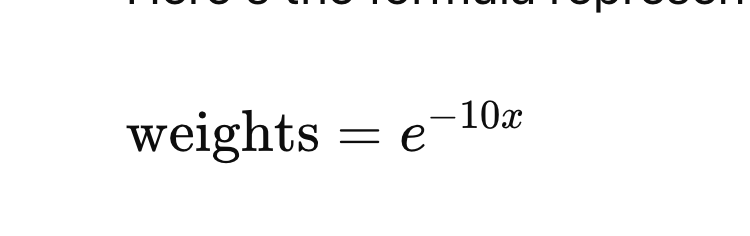

In [53]:
# final weights 

weights = np.exp(np.linspace(0, -10, len(y_train_filt)))

After comparing the graphs, we've noticed that increasing the value of 𝑘 compromises the AUC and only marginally improves the overall profit top 20. Therefore, we've decided to stick with this final weight as it strikes the best balance between performance and profit.
##### Comparing all the models using their default parameters, it's evident that logistic regression and XGBoost outperform the others in terms of both AUC accuracy and Profit top 20. This is why we chose to further explore only these two models.

## Models interpretations with default parameters  

### Important features in each models 

Important features refer to the specific variables or factors that significantly influence the outcome or prediction of a model. These features are crucial for understanding the underlying patterns and relationships within the data and are often used to make decisions or predictions. In the context of machine learning models like logistic regression and XGBoost, important features are identified based on their impact on the model's performance metrics, such as accuracy, AUC.

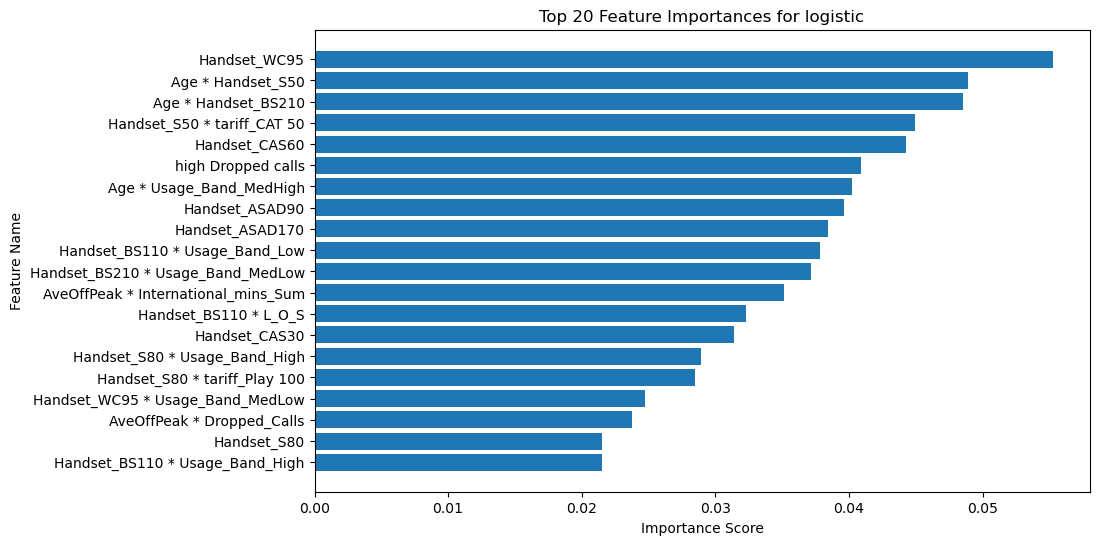

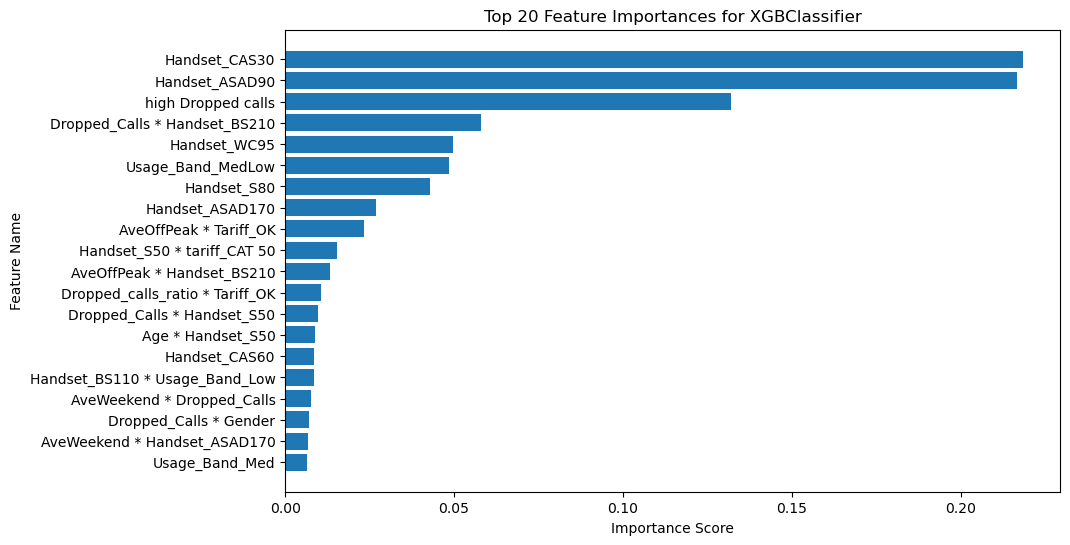

In [55]:
LR = LogisticRegression()
LR.fit(X_train_filt, y_train_filt)

# Get absolute coefficients for feature importance
coef_abs = np.abs(LR.coef_[0])
feature_importances = coef_abs / coef_abs.sum()  # Normalize to sum up to 1

# Plot feature importance for logistic regression model
impo_feat = pd.DataFrame({'feature': X_train_filt.columns, 'importance': feature_importances})
impo_feat = impo_feat.sort_values('importance', ascending=False)

# Plot feature importance as bar plot
top_n = 20  # Specify the number of top features to plot
top_n_features = impo_feat['feature'].head(top_n)
top_n_importances = impo_feat['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for logistic')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()


gb = XGBClassifier()
gb.fit(X_train_filt, y_train_filt)
feature_importances = gb.feature_importances_
# Plot feature importance for logistic regression model
impo_feat = pd.DataFrame({'feature': X_train_filt.columns, 'importance': feature_importances})
impo_feat = impo_feat.sort_values('importance', ascending=False)

# Plot feature importance as bar plot
top_n = 20  # Specify the number of top features to plot
top_n_features = impo_feat['feature'].head(top_n)
top_n_importances = impo_feat['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for {name}')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

The plots display the top 20 most significant features without considering any applied weights. Interestingly, the average minimum cost feature is notably absent from both plots. This observation underscores the importance of feature selection and weighting techniques in model training, as it suggests that the average minimum cost may not have a significant impact on the prediction outcomes compared to other features.

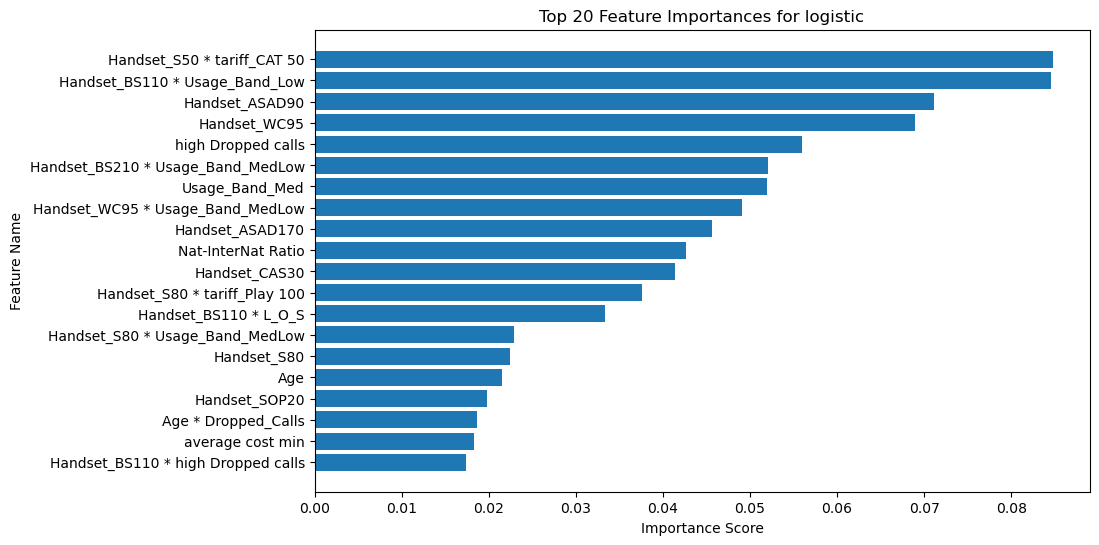

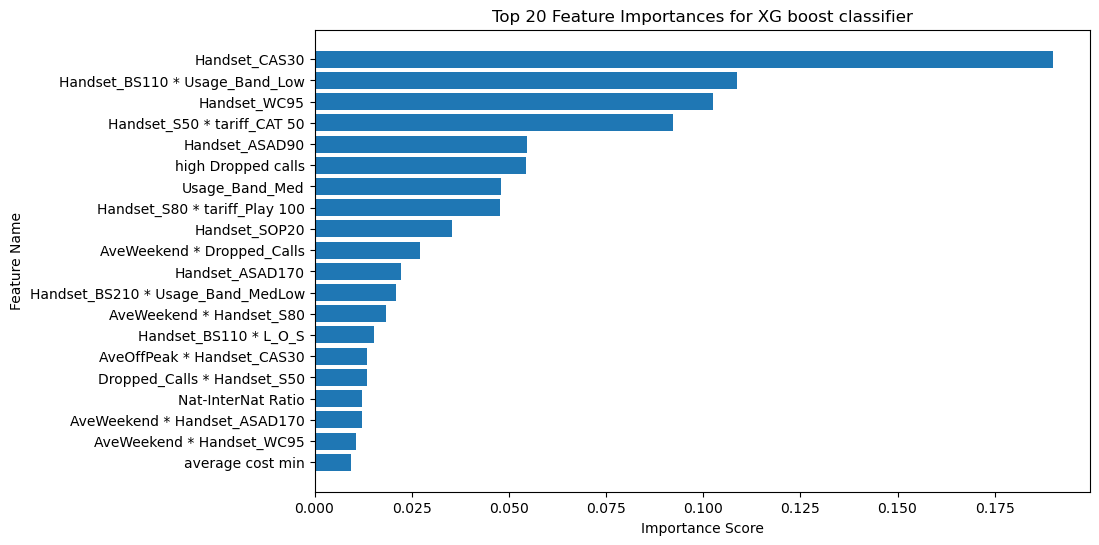

In [56]:
LR = LogisticRegression()
LR.fit(X_train_filt, y_train_filt, sample_weight= weights )

coef_abs = np.abs(LR.coef_[0])
feature_importances = coef_abs / coef_abs.sum()  

impo_feat = pd.DataFrame({'feature': X_train_filt.columns, 'importance': feature_importances})
impo_feat = impo_feat.sort_values('importance', ascending=False)

top_n = 20  
top_n_features = impo_feat['feature'].head(top_n)
top_n_importances = impo_feat['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for logistic')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

gb.fit(X_train_filt, y_train_filt, sample_weight= weights)
feature_importances = gb.feature_importances_

impo_feat = pd.DataFrame({'feature': X_train_filt.columns, 'importance': feature_importances})
impo_feat = impo_feat.sort_values('importance', ascending=False)

top_n = 20  
top_n_features = impo_feat['feature'].head(top_n)
top_n_importances = impo_feat['importance'].head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_n_features, top_n_importances)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title(f'Top {top_n} Feature Importances for XG boost classifier')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

After we added weights, something interesting happened: the "average minimum cost" feature now shows up in both plots of the top 20 important features. This change suggests that by giving more importance to certain features during model training, we can highlight their significance in making predictions. So, it seems like the "average minimum cost" feature has become more important in helping the model make decisions. This shows how adjusting the weights can improve the model's performance by focusing on key factors.

This mirrors real-world scenarios where data scientists often prioritize optimizing models based on AUC to highlight overall predictive accuracy. Nevertheless, we also anticipate management's apprehensions regarding resource limitations.



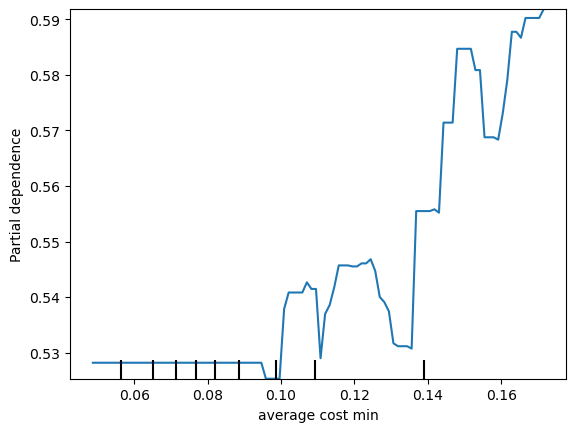

In [59]:
display = PartialDependenceDisplay.from_estimator(gb, X_train_filt, features=['average cost min'], kind='average')

plt.show()



Partial dependence plots (PDPs) serve as a widely used method for interpreting the correlation between a feature and the predicted outcome within machine learning models. These plots illustrate the marginal impact of a feature on the predicted outcome while considering the collective impacts of all other features.

In our analysis, it's evident that as the average cost min increases, the influence of the 'average cost min' feature on our model becomes more pronounced. By applying exponential weights, we effectively prioritize the instances where the 'average cost min' is greater than 0.1, disregarding those below this threshold.

## Hyperparameter Tunning

First of all, the KFold is designed for randomized search. Due to the imbalance classification, the stratification is adopted. Besides, grid search runs for good especially when computation sources are limited. Instead, randomized search is used for its cost-efficiency. Mostly, randomized search has similar performance with grid search.


A grid search has the advantage that all possible combinations of tuning parameters are considered and the optimal combination is found. This procedure however becomes extremely time-consuming if a lot of tuning parameters are involved. In such a situation, a randomized search is better to save computation time. A randomized search simply tries m possible combinations out of n cases and returns the best performing one from this subset.

In [60]:
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 1. Logistic regression

In logistic regression, most hyperparameters are fixed according to binary classfication. The variant hyperparameter could be C. C represents inverse of regularization strength. Smaller values of C specify stronger regularization. The default value of C is 1 and it must be a positive float.

In [88]:

param_grid = {
    'C': np.arange(0.1, 100.1, 5)
}

weights = np.exp(np.linspace(0, -10, len(y_train_filt)))

lr = LogisticRegression()
lr_rs = RandomizedSearchCV(lr, param_grid, cv=skf, scoring='roc_auc')
lr_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

print(lr_rs.best_params_,lr_rs.best_score_ )

{'C': 5.1} 0.8778032732371617


In [89]:

lr_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(),
                   param_distributions={'C': array([ 0.1,  5.1, 10.1, 15.1, 20.1, 25.1, 30.1, 35.1, 40.1, 45.1, 50.1,
       55.1, 60.1, 65.1, 70.1, 75.1, 80.1, 85.1, 90.1, 95.1])},
                   scoring='roc_auc')

In [90]:
y_pred_Log= lr_rs.predict(X_val) #### y_pred changes for all

prof_Logisticregression = profit_top_20(X_val,y_pred_Log, y_val)
prof_Logisticregression

cost    4.471014
dtype: float64

k=1 | Profit: cost    4.479056
dtype: float64 | AUC: 0.9130016492578339
k=4 | Profit: cost    4.471014
dtype: float64 | AUC: 0.908512002932014
k=7 | Profit: cost    4.471014
dtype: float64 | AUC: 0.8899807586586036
k=10 | Profit: cost    4.471014
dtype: float64 | AUC: 0.8845824934335104
k=13 | Profit: cost    4.479056
dtype: float64 | AUC: 0.8675477979353734
k=16 | Profit: cost    4.471014
dtype: float64 | AUC: 0.8145806609248061
k=19 | Profit: cost    4.471014
dtype: float64 | AUC: 0.8006459593183066
k=22 | Profit: cost    4.471014
dtype: float64 | AUC: 0.7947666605583044
k=25 | Profit: cost    4.477933
dtype: float64 | AUC: 0.7886124854926395
k=28 | Profit: cost    4.480496
dtype: float64 | AUC: 0.7884903182456782
k=31 | Profit: cost    4.480496
dtype: float64 | AUC: 0.7786863966770509
k=34 | Profit: cost    4.480496
dtype: float64 | AUC: 0.7743418239569971
k=37 | Profit: cost    4.480496
dtype: float64 | AUC: 0.7666376519455134
k=40 | Profit: cost    4.480496
dtype: float64 | AUC: 0

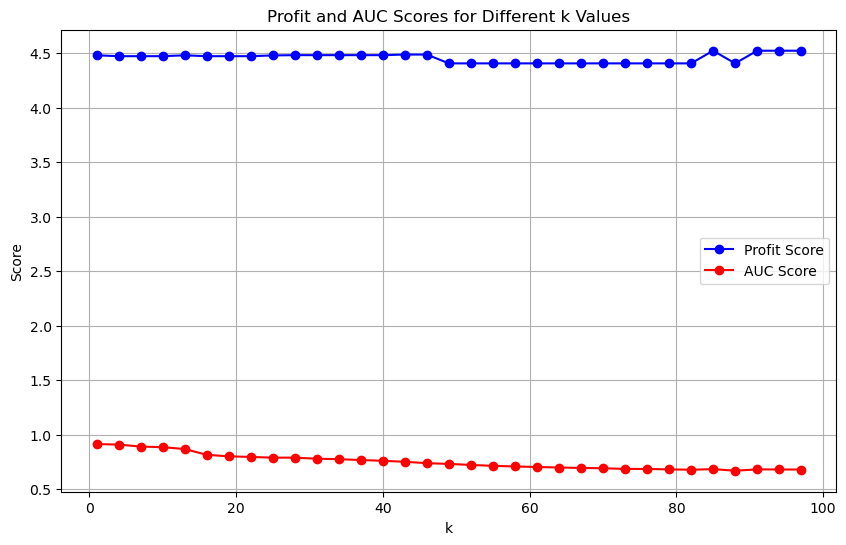

In [92]:
# Lists to store the profit and AUC scores
profit_scores = []
auc_scores = []

# Iterate over a range of k values
for k in range(1, 100, 3):
    
    
    weights = np.exp(np.linspace(0, -k, len(y_train_filt)))
    
    lr_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

    y_pred_Log = lr_rs.predict(X_val)
    y_pred_proba_Log = lr_rs.predict_proba(X_val)[:, 1]  # Predicted probabilities for AUC
    
    
    prof_Logisticregression = profit_top_20(X_val, y_pred_Log, y_val)
    
    auc_score = roc_auc_score(y_val, y_pred_proba_Log)
    
    profit_scores.append((k, prof_Logisticregression))
    auc_scores.append((k, auc_score))

    print(f"k={k} | Profit: {prof_Logisticregression} | AUC: {auc_score}")

k_values, profit_values = zip(*profit_scores)
_, auc_values = zip(*auc_scores)

# Plot the profit scores against the k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, profit_values, marker='o', linestyle='-', color='b', label='Profit Score')
plt.plot(k_values, auc_values, marker='o', linestyle='-', color='r', label='AUC Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Profit and AUC Scores for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

### 2. Boosting - Gradient Boosting

In [67]:
gb = XGBClassifier()
gb.fit(X_train_filt, y_train_filt, sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
# hyperparameters tunning
param_grid = {
    'n_estimators': np.arange(1,301,10),
    'max_depth': np.arange(1, 101, 5),  
    'learning_rate': np.arange(0.01,1,0.1)
}

# Create RandomizedSearchCV with custom scoring
gb = XGBClassifier()
gb_rs = RandomizedSearchCV(gb, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)
gb_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)

# Print the best parameters and best score
print(gb_rs.best_params_)

{'n_estimators': 141, 'max_depth': 31, 'learning_rate': 0.51}


In [69]:
# Create a boosting model with the best parameters
gb_rs = XGBClassifier(n_estimators=221, max_depth=21, learning_rate=0.001, gamma = 0.1)

# Fit the model to the training data
gb_rs.fit(X_train_filt, y_train_filt,sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=21, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=221, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

k=1 | Profit: cost    3.931702
dtype: float64 | AUC: 0.9278220634048012
k=4 | Profit: cost    4.146841
dtype: float64 | AUC: 0.9225688717854743
k=7 | Profit: cost    4.182572
dtype: float64 | AUC: 0.8932869097794881
k=10 | Profit: cost    4.220082
dtype: float64 | AUC: 0.8926531671858775
k=13 | Profit: cost    3.876909
dtype: float64 | AUC: 0.884177814427952
k=16 | Profit: cost    4.162229
dtype: float64 | AUC: 0.8717702034084662
k=19 | Profit: cost    3.916937
dtype: float64 | AUC: 0.8612485492639423
k=22 | Profit: cost    3.920824
dtype: float64 | AUC: 0.8593167796713702
k=25 | Profit: cost    3.84282
dtype: float64 | AUC: 0.8459012888644554
k=28 | Profit: cost    3.872283
dtype: float64 | AUC: 0.8379909596237247
k=31 | Profit: cost    3.918374
dtype: float64 | AUC: 0.8051890538146722
k=34 | Profit: cost    4.221453
dtype: float64 | AUC: 0.8052806792498931
k=37 | Profit: cost    3.773306
dtype: float64 | AUC: 0.7845580599841183
k=40 | Profit: cost    4.145066
dtype: float64 | AUC: 0.

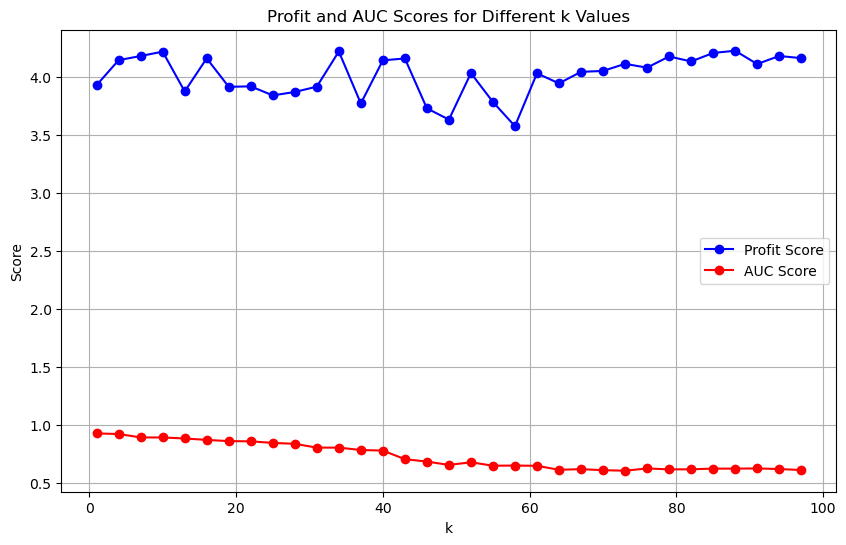

In [83]:
# Initialize lists to store the profit and AUC scores
profit_scores = []
auc_scores = []

# Iterate over a range of k values
for k in range(1, 100, 3):
    # Compute weights
    weights = 100 * np.exp(np.linspace(0, -k, len(y_train_filt)))
    
    # Fit the model
    gb_rs.fit(X_train_filt, y_train_filt, sample_weight=weights)
    
    # Predict on the validation set
    y_pred_gb_rs = gb_rs.predict(X_val)
    y_pred_proba_gb_rs = gb_rs.predict_proba(X_val)[:, 1]  # Predicted probabilities for AUC
    
    # Compute the profit score
    prof_gb_rs = profit_top_20(X_val, y_pred_gb_rs, y_val)
    
    # Compute the AUC score
    auc_score = roc_auc_score(y_val, y_pred_proba_gb_rs)
    
    # Store the profit score and AUC score along with the corresponding k value
    profit_scores.append((k, prof_gb_rs))
    auc_scores.append((k, auc_score))

    print(f"k={k} | Profit: {prof_gb_rs} | AUC: {auc_score}")

# Separate the k values, profit scores, and AUC scores for plotting
k_values, profit_values = zip(*profit_scores)
_, auc_values = zip(*auc_scores)

# Plot the profit scores and AUC scores against the k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, profit_values, marker='o', linestyle='-', color='b', label='Profit Score')
plt.plot(k_values, auc_values, marker='o', linestyle='-', color='r', label='AUC Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Profit and AUC Scores for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

These plots demonstrate the evolution of AUC and Profit Top 20 as we adjust the parameter "k," while also considering the impact of our applied weights

## Finale model selection

After conducting a comprehensive comparison between Logistic Regression and XGBoost based on both AUC and Profit Top 20 metrics, we have decided to proceed with Logistic Regression as our chosen model.

#### Reflection

We observed that XGBoost performed worse on the final leaderboard compared to the preliminary one (went from 14th place to 23th in the second leaderboard). 

To understand why XGBoost performed worse on the final leaderboard compared to the preliminary one, we need to delve into various potential factors that could have contributed to this outcome. 

One possibility is that XGBoost may have overfit the training data, performing exceptionally well on the training set but struggling when faced with unseen data. This raises concerns about the model's stability and its ability to generalize to new, unseen instances.

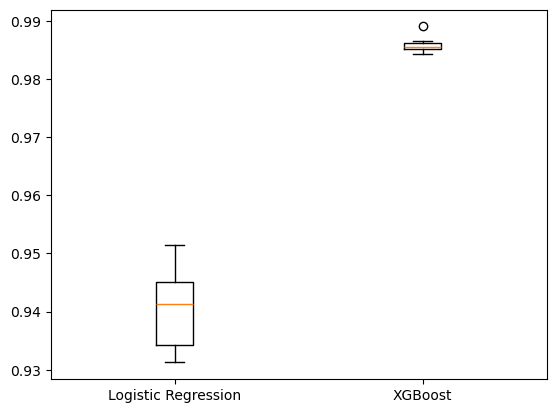

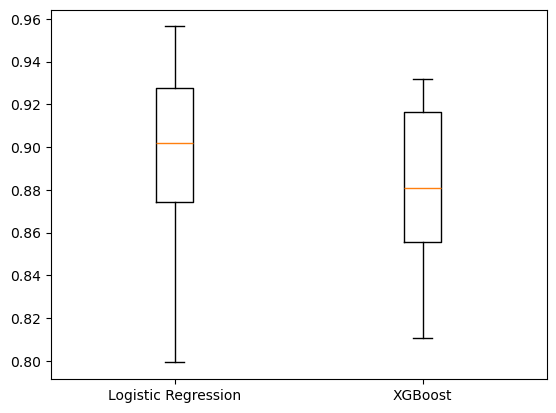

In [99]:
models = {
    "Logistic Regression":lr_rs ,
    "XGBoost": gb_rs
}

results = []

## with train data 

for model_name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model,X_train_filt, y_train_filt, cv=kf, scoring='roc_auc')
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.show()

#With Test data


results = []
for model_name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model,X_val, y_val, cv=kf, scoring='roc_auc')
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.show()

To prevent overfitting in XGBoost, the model's performance is penalized by adjusting the parameter gamma, which controls the number of leaf nodes in the tree. The model's objective function combines two parts: the first measures how well the model fits the data, and the second imposes a penalty for the complexity of the tree. Gamma adds a penalty for each additional leaf node, discouraging overly complex trees. By tuning gamma, we adjust the strength of this penalty, ensuring the model remains both accurate and simple, thus avoiding overfitting.





Here, we've added another aspect to our objective function to penalize complexity:


Objective= Loss + γ×Number of Leaf Nodes

Second possibility is that we initially put a lot of emphasis on predicting the top 20 outcomes accurately. We did this by utilizing weights that decrease rapidly to our data, which helped us prioritize these important predictions. However, we noticed that despite our efforts to maximize profit in the top 20, our overall model performance, measured by AUC, was around 70%.

This helps explain why our model performed worse on the final leaderboard compared to the preliminary one.

To counter this issue, we made sure to take an AUC higher than 0.89 while aiming a high profit top 20.




In our analysis, we often faced a conflict between making profit top 20 high and getting the most accurate predictions. This happens a lot in real life, where data experts have to make a trade-off between accurate predictions and money/resources. While focusing on getting good predictions can help us understand how well a model works, it might not always help a business make the most money. So, it's important to find a middle ground between making accurate predictions and being practical. 

That's why our challenge was to identify the top 20 choices that would bring in the most profit without sacrificing too much on our accuracy measure, AUC. We needed to strike a balance between maximizing profit and maintaining high accuracy in our predictions.

Lastly, in the preprocessing, a few adjustments could have been made. More variables could have been using different feature selection techniques. There were 82 features in the final training set used, and this could have contributed to the overfitting. Furthermore, using correlation as a feature selection technique was not a good idea because we would less likely capture non linear relationships. The connection time column that we've used might've introduced bias since there is censoring, end times are not observed. Also, we could've used normalization to preprocess some numerical features. There were quite a few extreme values but they remained in the data because we thought outliers helped in our prediction. This meant that middle ground observations were less likely to be predicted as a churner.

In [ ]:
# retrive the result from the best model

import os

y_pred_proba_test = gb_rs.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv(os.path.join(os.path.expanduser('~'), 'Desktop', 'Model_Result_Final.csv'), index=False)